## Storm Mode/Precipitation Type Classification for derived 3D dBZ of WRF Simulations. 

**Based on the Convective/Stratiform separation on the 12 $\sigma$ level of reflectivity.**

**Calculate the max. composite reflectivity instead of REFLC_10CM from CONUS1 runs.**

**Storm Mode Classification starts from the Composite dBZ (Rain Area) identification, and add another mode: Ordinary (Non-Deep) Convective Cores (OCC) to represent shallow conveciton.**

**For [High Resolution WRF Simulations of the Current and Future Climate of North America](https://rda.ucar.edu/datasets/ds612.0/).**

**Hungjui Yu 20211117**

In [51]:
import sys
# from shutil import copyfile
import time
import datetime as dt
# import pytz
from netCDF4 import Dataset # MFDataset
import numpy as np
from scipy.ndimage import label, generate_binary_structure
import xarray as xr
import wrf
from wrf import (getvar, interplevel, destagger)

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import matplotlib as mpl
import matplotlib.pyplot as plt

modules_path = '/glade/work/hungjui/Research_Test/WRF_dBZ_Cloud_Classification/WRF_dBZ_Class_CONUS1/Modules'
if ( modules_path not in sys.path ):
    sys.path = [modules_path] + sys.path
    # print(sys.path)
    
import storm_mode_class5 as stm

**Function: Set input files paths and names:**

In [52]:
def set_input_names(file_date):

    file_path_1_conus = '/gpfs/fs1/collections/rda/data/ds612.0'
    file_path_1_dbz = '/glade/scratch/hungjui/DATA_WRF_CONUS_1_dBZ_v1.0'
    file_path_2 = '/' + wrf_sim_type # '/CTRL3D'
    file_path_3 = '/{}'.format(file_date.strftime('%Y'))

    file_names = dict( dbz = file_path_1_dbz
                           + file_path_2 
                           # + '/20130913' 
                           + '/20110427' # file_path_3 
                           + '/wrf3d_d01_' + wrf_sim_type[0:-2] + '_dbz_{}.nc'.format(file_date.strftime('%Y%m%d'))
                       , Z = file_path_1_conus
                           + file_path_2 
                           + file_path_3 
                           + '/wrf3d_d01_' + wrf_sim_type[0:-2] + '_Z_{}.nc'.format(file_date.strftime('%Y%m%d'))
                     )
    
    return file_names

**Open & Derive data directly:**

In [53]:
## Set wrf simulation type:
wrf_sim_type = 'CTRL3D'
# wrf_sim_type = 'PGW3D'

## Set date time:
case_date_time = dt.datetime(2011,4,27) 
# case_date_time = dt.datetime(2013,9,13) 

file_name_list = set_input_names(case_date_time)
print(file_name_list)

{'dbz': '/glade/scratch/hungjui/DATA_WRF_CONUS_1_dBZ_v1.0/CTRL3D/20110427/wrf3d_d01_CTRL_dbz_20110427.nc', 'Z': '/gpfs/fs1/collections/rda/data/ds612.0/CTRL3D/2011/wrf3d_d01_CTRL_Z_20110427.nc'}


In [54]:
## Set hour:
## 0:00, 1:03, 2:06, 3:09, 4:12, 5:15, 6:18, 7:21
time_hour_idx = 4

## Get dBZ and CS mask data :
ds_wrf_dbz = xr.open_dataset(file_name_list['dbz'])

da_wrf_dbz = ds_wrf_dbz['dBZ'].isel(Time=time_hour_idx)
da_wrf_CSmask = ds_wrf_dbz['CS_mask'].isel(Time=time_hour_idx)

## Calculate the max. composite dBZ:
da_wrf_reflc = da_wrf_dbz.max(dim='bottom_top')

## Get geopotential height:
data_wrf_z_unstag = wrf.destagger(getvar(Dataset(file_name_list['Z']), 'Z', timeidx=time_hour_idx, meta=False), 0)


# da_wrf_dbz[0,:,:].plot()
# da_wrf_reflc.plot()
# print(data_wrf_z_unstag.shape)

**Function: Reflectivity Geo-Height Interpolation (linearly):**

In [55]:
def dbz_geoh_interp(refl, geoH, interp_lev_km):
    
    # # Use linear Z for interpolation:
    refl_linear = 10**(refl/10.)
    
    ## Interpolation:
    ## !!! convert interpolation level to the same as geo-H (meter) !!!
    refl_linear_lev = interplevel(refl_linear, geoH, interp_lev_km*1000)
    
    ## Convert back to dBz after interpolation:
    refl_lev = 10.0 * np.log10(refl_linear_lev)
    
    return refl_lev

**Function: Storm Mode Classification:**

In [56]:
def storm_mode_class( refl, reflc, CS_mask
                    , geoH
                    , resolution_WRF = 4 # km grid spacing 
                    , dbz_threshold = 30 # 40 # dBZ
                    , height_threshold = 8 # 10 # km
                    , WCC_threshold = 800 # 1000 # km^2
                    , BSR_threshold = 40000 # km^2
                    ):
    
    ## ======================================================================
    ## 
    ## Run:     storm_mode_class(da_wrf_dbz, da_wrf_reflc, da_wrf_CSmask, data_wrf_z_unstag)
    ## 
    ## Input:
    ## refl:    Derived 3D reflectivity
    ## reflc:   Derived 2D max. reflectivity composite
    ## CS_mask: 2D Convective/Stratifom mask at 12th sigma level (~1.5–2km agl.)
    ## geoH:    3D Geopotential-height (msl. in meter)
    ##
    ## ======================================================================
    
    
    ## Set pixel numbers required for WCC & BSR:
    WCC_pixels_required = WCC_threshold/(resolution_WRF**2)
    BSR_pixels_required = BSR_threshold/(resolution_WRF**2)
    
    ## Interpolate reflectivity to height threshold:
    refl_lev = dbz_geoh_interp(refl, geoH, height_threshold)
    
    ## Generate a structuring element that will consider features connected even if they touch diagonally:
    se = generate_binary_structure(2, 2)
    
    
    ## ======================================================================
    ## 1:
    ## Threshold - Max. Composite dBZ & Convective Mask:
    reflc_boo_tmp = np.where( (reflc >= dbz_threshold) & (CS_mask > 0), 1, 0 )
    
    ## DCC & SCC masking:
    DCC_mask = np.where( ((reflc_boo_tmp == 1) & (refl_lev >= dbz_threshold)), 1, 0 )
    SCC_mask = np.where( ((reflc_boo_tmp == 1) & (refl_lev < dbz_threshold)), 1, 0 )
    
    
    ## ======================================================================
    ## 2:
    ## WCC & DWCC masking:
    labeled_array_reflc_boo, num_features_reflc_boo = label( reflc_boo_tmp, structure=se )
    
    WCC_mask = np.zeros_like(labeled_array_reflc_boo)
    DWCC_mask = np.zeros_like(labeled_array_reflc_boo)

    for feati in np.arange(num_features_reflc_boo):
        feat_id = feati+1
        if ( (labeled_array_reflc_boo == feat_id).sum() > WCC_pixels_required ):
            if ( (DCC_mask[np.where(labeled_array_reflc_boo == feat_id)]).sum() == 0 ):
                WCC_mask = np.where( (labeled_array_reflc_boo == feat_id), 1, WCC_mask )
            else:
                DWCC_mask = np.where( (labeled_array_reflc_boo == feat_id), 1, DWCC_mask )
            
    
    ## ======================================================================
    ## 3:
    ## DCC mask adjustment for DWCC:
    DCC_mask[np.where(DWCC_mask == 1)] = 0
    
    ## SCC mask adjustment for WCC and DWCC:
    SCC_mask[np.where( (WCC_mask) | (DWCC_mask == 1) )] = 0
        
    ## ======================================================================
    ## 4:
    ## Threshold - Stratiform Mask:
    stratiform_boo_tmp = np.where( (CS_mask == 0), 1, 0 )
    
    ## BSR masking:
    labeled_array_BSR, num_features_BSR = label( stratiform_boo_tmp, structure=se )
    
    BSR_mask = np.zeros_like(labeled_array_BSR)

    for feati in np.arange(num_features_BSR):
        feat_id = feati+1
        if ( (labeled_array_BSR==feat_id).sum() > BSR_pixels_required ):
            BSR_mask = np.where( (labeled_array_BSR==feat_id), 1, BSR_mask )
    
    
    return DCC_mask, SCC_mask, WCC_mask, DWCC_mask, BSR_mask
    

### Main Program: Storm Mode Classification:

**Use the Stomr Mode module:**

In [57]:
start = time.time()

grid_res = 4 # 4-km grid resolution
thresholds_type = 'moderate'
# thresholds_type = 'strong'

DCC_mask, OCC_mask, WCC_mask, DWCC_mask, BSR_mask = stm.storm_mode_c5( da_wrf_dbz
                                                                     , da_wrf_reflc
                                                                     , da_wrf_CSmask
                                                                     , data_wrf_z_unstag
                                                                     , grid_res
                                                                     , thresholds_type
                                                                     )

Storm_Mode = stm.merge_to_Storm_Mode(DCC_mask, OCC_mask, WCC_mask, DWCC_mask, BSR_mask)

end = time.time()

print("RUNTIME：%f SEC" % (end - start))
print("RUNTIME：%f MIN" % ((end - start)/60))
print("RUNTIME：%f HOUR" % ((end - start)/3600))

RUNTIME：9.245026 SEC
RUNTIME：0.154084 MIN
RUNTIME：0.002568 HOUR


**Use functions defined in the script:**

In [58]:
# start = time.time()

# DCC_mask, SCC_mask, WCC_mask, DWCC_mask, BSR_mask = storm_mode_class( da_wrf_dbz
#                                                                     , da_wrf_reflc
#                                                                     , da_wrf_CSmask
#                                                                     , data_wrf_z_unstag)

# end = time.time()

# print("RUNTIME：%f SEC" % (end - start))
# print("RUNTIME：%f MIN" % ((end - start)/60))
# print("RUNTIME：%f HOUR" % ((end - start)/3600))

In [59]:
## Test: Intersection of Modes:

# Storm_Mode_Int = DCC_mask + SCC_mask + WCC_mask + DWCC_mask + BSR_mask
# print(np.max(Storm_Mode_Int))

In [60]:
## Merge the masks array for plotting:

# Storm_Mode = np.zeros_like(DCC_mask)
# Storm_Mode = np.where( (DCC_mask==1), 1, Storm_Mode )
# Storm_Mode = np.where( (SCC_mask==1), 2, Storm_Mode )
# Storm_Mode = np.where( (WCC_mask==1), 3, Storm_Mode )
# Storm_Mode = np.where( (DWCC_mask==1), 4, Storm_Mode )
# Storm_Mode = np.where( (BSR_mask==1), 5, Storm_Mode )

# # Storm_Mode[np.where(Storm_Mode == 0)] = np.nan

### Test plot:

**Function: creating new map:**

In [61]:
def new_map(fig):
    
    # proj = ccrs.LambertConformal()
    proj = ccrs.PlateCarree(central_longitude=0)
    
    # ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax = plt.axes(projection=proj)
    
    ## Set extent:
    # ax.set_global()
    
    ## CONUS:
    # ax.set_extent([-139, -55, 16, 60], crs=proj)    
    ## 9/13 case:
    # ax.set_extent([-115, -95, 32, 43], crs=proj)    
    ## 4/27 case:
    ax.set_extent([-96, -84, 33, 41], crs=proj)
    
    ## Add coast lines:
    ax.coastlines('10m', 'black', linewidth=1)
    
    ## Add features:
    ax.add_feature(cfeat.BORDERS)
    ax.add_feature(cfeat.OCEAN, edgecolor=None, fc='none')
    
    ## Grab state shapefile:
    state_borders = cfeat.NaturalEarthFeature(category='cultural', 
                                              name='admin_1_states_provinces_lines', 
                                              scale='110m', 
                                              facecolor='none',
                                              edgecolor='k'
                                             )
    
    ax.add_feature(state_borders, linewidth=0.8)
    
    ## Add the gridlines:
    latlon_grid_int = 2
    ax_gl = ax.gridlines(crs=ccrs.PlateCarree()
                        ,linewidth=0.5
                        ,color='#454545' 
                        ,alpha=0.9
                        ,linestyle='--'
                        ,draw_labels=True 
                        ,dms=True
                        ,x_inline=False 
                        ,y_inline=False
                        ,xlocs=np.arange(-180, 181, latlon_grid_int)
                        ,ylocs=np.arange(-90, 91, latlon_grid_int)
                        )
    ax_gl.top_labels = False
    ax_gl.right_labels = False
    ax_gl.bottom_labels = True
    ax_gl.left_labels = True
    ax_gl.xlabel_style = {'size': 12, 'weight': 'bold'}
    ax_gl.ylabel_style = {'size': 12, 'weight': 'bold'}
    
    
    return ax

**Do the plot:**

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


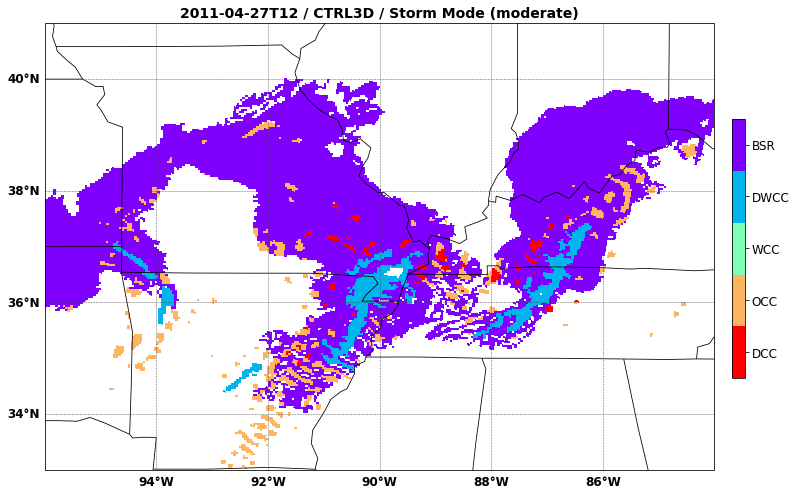

In [62]:
fig = plt.figure(figsize=(12,9))
ax1 = new_map(fig)
# ax1 = plt.axes(projection = ccrs.LambertConformal(central_longitude=-100, central_latitude=40))
# ax1 = plt.axes(projection = ccrs.PlateCarree())

# DCC_mask[np.where(DCC_mask == 1)] = 1
# WCC_mask[np.where(WCC_mask == 1)] = 2
# DWCC_mask[np.where(DWCC_mask == 1)] = 3
# BSR_mask[np.where(BSR_mask == 1)] = 4

plotting_var = Storm_Mode
# plotting_var_2 = WCC_mask
# plotting_var_3 = DWCC_mask
plotting_lon = da_wrf_reflc.XLONG
plotting_lat = da_wrf_reflc.XLAT

cf1 = ax1.pcolormesh( plotting_lon, plotting_lat, plotting_var # + plotting_var_2 + plotting_var_3
                    , cmap=plt.cm.get_cmap('rainbow_r', 5)
                    , vmin=1
                    , vmax=5
                    , shading='auto'
                    )
# cf1 = ax1.pcolormesh( plotting_lon, plotting_lat, plotting_var_2
#                     , cmap=plt.cm.get_cmap('rainbow_r', 4)
#                     , vmin=1
#                     , vmax=4
#                     , shading='auto'
#                     )
cf1.cmap.set_under('w')

## Title:
cf1_title = plt.title( np.datetime_as_string(da_wrf_dbz.Time.data, unit='h')
                     + ' / ' + wrf_sim_type
                     + ' / Storm Mode'
                     + ' ('  + thresholds_type + ')'
                     # + ' / ' + '$\sigma$-Level index: ' + str(interp_vertical_lev)
                     ,fontsize=14 
                     ,fontweight='bold'
                     # ,loc='left'
                     )
# plt.title('right', loc='right')

## Colorbar:
cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])
cbar = fig.colorbar(cf1, 
                    cax=cbar_ax, 
                    fraction=0.04, 
                    ticks=np.arange(1, 6, 1), 
                    boundaries=np.arange(0.5, 6.5, 1))
cbar.ax.tick_params(labelsize=12)
cbar.set_ticklabels(['DCC', 'OCC', 'WCC', 'DWCC', 'BSR'])
# cbar_title = plt.title('[dBZ]', fontsize=12, y=-0.1)

## Save figure:
# fig_file_name = './' + np.datetime_as_string(da_wrf_dbz.Time.data, unit='h') + '_StormMode_.png'
fig_file_name = './' + np.datetime_as_string(da_wrf_dbz.Time.data, unit='h') + '_StormMode_' + thresholds_type[0:3] + '.png'

plt.savefig(fig_file_name, bbox_inches='tight', dpi=300)


In [63]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


<font color='teal'>**Supplement Codes:**</font>

In [64]:
# reflc_boo_tmp = np.where( (da_wrf_reflc >= 30) & (da_wrf_CSmask != 0), 1, 0 )
# # print(reflc_boo_tmp)
# labeled_array_WCC, num_features_WCC = label( reflc_boo_tmp, structure=generate_binary_structure(2, 2) )
# # print(labeled_array_WCC)
# feat_id = 6
# print(DCC_mask[np.where(labeled_array_WCC == feat_id)].sum())
# print((labeled_array_WCC == feat_id).sum())
# print(labeled_array_WCC.shape)

In [65]:
# da_refl_lev = dbz_geoh_interp(da_wrf_dbz, data_wrf_z_unstag, 10)
# # da_refl_lev.plot()
# # da_wrf_CSmask.plot()

# echotop_boo_tmp = np.where( (da_refl_lev >= 30.0) & (da_wrf_CSmask != 0), 1, 0 )
# # echotop_boo = xr.zeros_like(da_wrf_reflc).rename('echotop_boolean')
# # echotop_boo.data = echotop_boo_tmp
# # echotop_boo.plot()

# se = generate_binary_structure(2, 2)

# labeled_array_DCC, num_features_DCC = label( echotop_boo_tmp, structure=se )

# DCC_mask = np.where( (labeled_array_DCC > 0.0), 1, 0 )
# # da_DCC_mask = xr.zeros_like(da_wrf_reflc).rename('DCC_mask')
# # da_DCC_mask.data = DCC_mask
# # da_DCC_mask.plot()

# reflc_boo_tmp = np.where( (da_wrf_reflc >= 30.0) & (da_wrf_CSmask != 0), 1, 0 )
# # reflc_boo = xr.zeros_like(da_wrf_reflc).rename('reflc_bpplean')
# # reflc_boo.data = reflc_boo_tmp
# # reflc_boo.plot()

# labeled_array_WCC, num_features_WCC = label( reflc_boo_tmp, structure=se )

# WCC_mask = np.zeros_like(labeled_array_WCC)

# for feati in np.arange(num_features_WCC):
#     feat_id = feati+1
#     if ( (labeled_array_WCC==feat_id).sum() > 800/(4**2) ):
#         WCC_mask = np.where( (labeled_array_WCC==feat_id), 1, WCC_mask )
    
# # da_WCC_mask = xr.zeros_like(da_wrf_reflc).rename('WCC_mask')
# # da_WCC_mask.data = WCC_mask
# # da_WCC_mask.plot()

